# Anders exepriments

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'beb606918461c91b007f25a007b71466d94cf516'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from analysis_functions import calculate_recall_success_sequences,calculate_recall_success
from analysis_functions import calculate_total_connections
from connectivity_functions import create_artificial_manager 
from plotting_functions import set_text, plot_winning_pattern

## Briding and overlap
The idea is that even if there are no positive connections between a sequence and its continuation when the overlap is way to big. The difference in negative connections should be higher. 

In [66]:
# Patterns parameters
hypercolumns = 4
minicolumns = 25
n_patterns = 10

dt = 0.001

# Manager properties
dt = 0.001
T_recalling = 5.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

tau_z_pre = 0.150
sigma = 0.0
tau_p = 1000.0

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre, sigma=sigma, tau_p=tau_p)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build chain protocol
overlap = 5
number_of_sequences = 2
half_width = 3
chain_protocol = Protocol()
units_to_overload = [i for i in range(overlap)]
sequences = chain_protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)
chain_protocol.cross_protocol(sequences, training_time=training_time,
                            inter_sequence_interval=inter_sequence_interval, epochs=epochs)
print(sequences)

# Train
manager.run_network_protocol(protocol=chain_protocol, verbose=True)

[[5, 6, 7, 0, 1, 2, 3, 4, 8, 9, 10], [11, 12, 13, 0, 1, 2, 3, 4, 14, 15, 16]]
('epochs', 0)
('epochs', 1)
('epochs', 2)


In [67]:
from_pattern = 7
to_pattern = 8
connectivity_bridge_1 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 13
to_pattern = 8
connectivity_bridge_2 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

print('right bridge', connectivity_bridge_1)
print('wrong bridge', connectivity_bridge_2)

('right bridge', -0.0045805416378557331)
('wrong bridge', -0.009470833947053333)


[5, 6, 7, 0, 1, 2, 3, 4, 8, 9, 10]
[11, 12, 13, 0, 1, 2, 3, 4, 14, 15, 16]


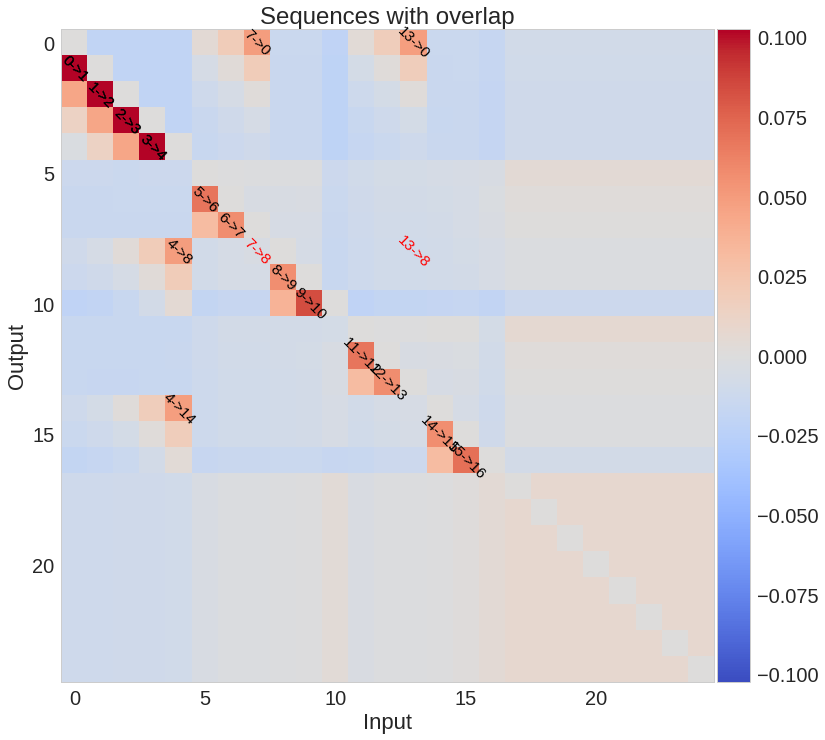

In [68]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

w = nn.w
w = w[:nn.minicolumns, :nn.minicolumns]

aux_max = np.max(np.abs(w))

cmap = 'coolwarm'
im = ax.imshow(w, cmap=cmap, interpolation='None', vmin=-aux_max, vmax=aux_max)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.get_figure().colorbar(im, ax=ax, cax=cax)

# Add text
fontsize = 15
if True:
    for sequence in sequences:
        print(sequence)
        for i in range(len(sequence) - 1):
            coordinate_from = sequence[i]
            coordinate_to = sequence[i + 1]
            set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize)

coordinate_from = 7
coordinate_to = 8
set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize, color='red')
        
coordinate_from = 13
coordinate_to = 8
set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize, color='red')   

# Editing
ax.grid(False)
ax.set_title('Sequences with overlap')
ax.set_xlabel('Input')
ax.set_ylabel('Output');

Let's see what is going on under the hood

In [69]:
T_recall = 5.0
T_cue = 0.100
n = 1
# g_w = 10.0
# g_w_ampa = 5.0
patterns_indexes = sequences[0]
success_1 = calculate_recall_success(manager, T_recall=T_recall, I_cue=patterns_indexes[0],
                                     T_cue=T_cue, n=n, patterns_indexes=patterns_indexes)
print(success_1)

0.0


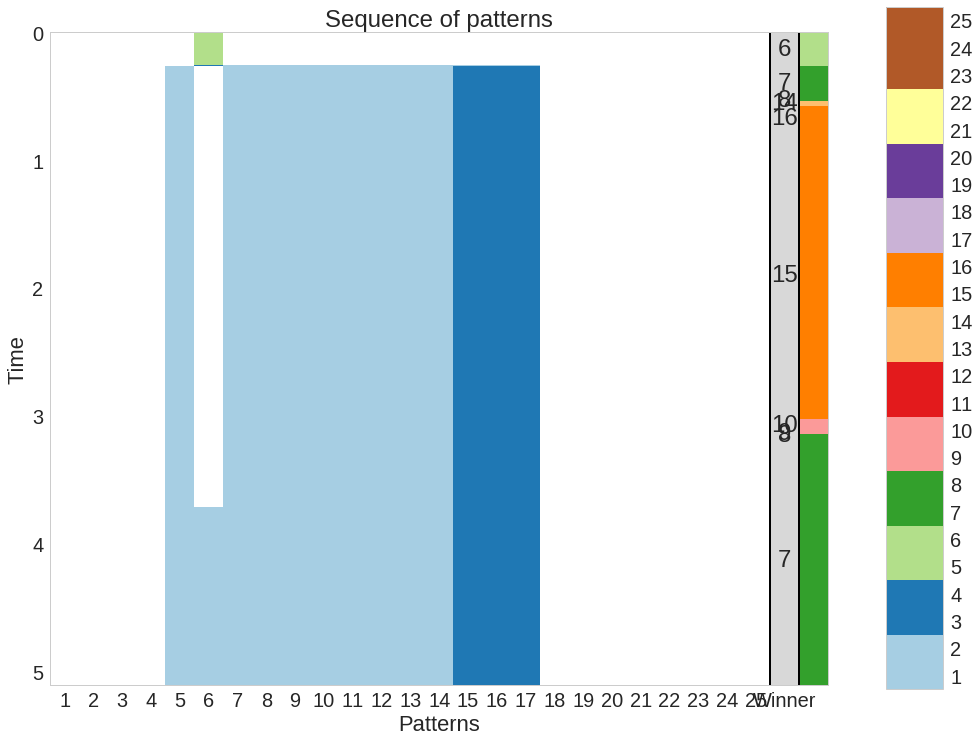

In [70]:
plot_winning_pattern(manager)

In [59]:
patterns_indexes = sequences[1]
success_2 = calculate_recall_success(manager, T_recall=T_recall, I_cue=patterns_indexes[0],
                                     T_cue=T_cue, n=n, patterns_indexes=patterns_indexes)
print(success_2)

0.0


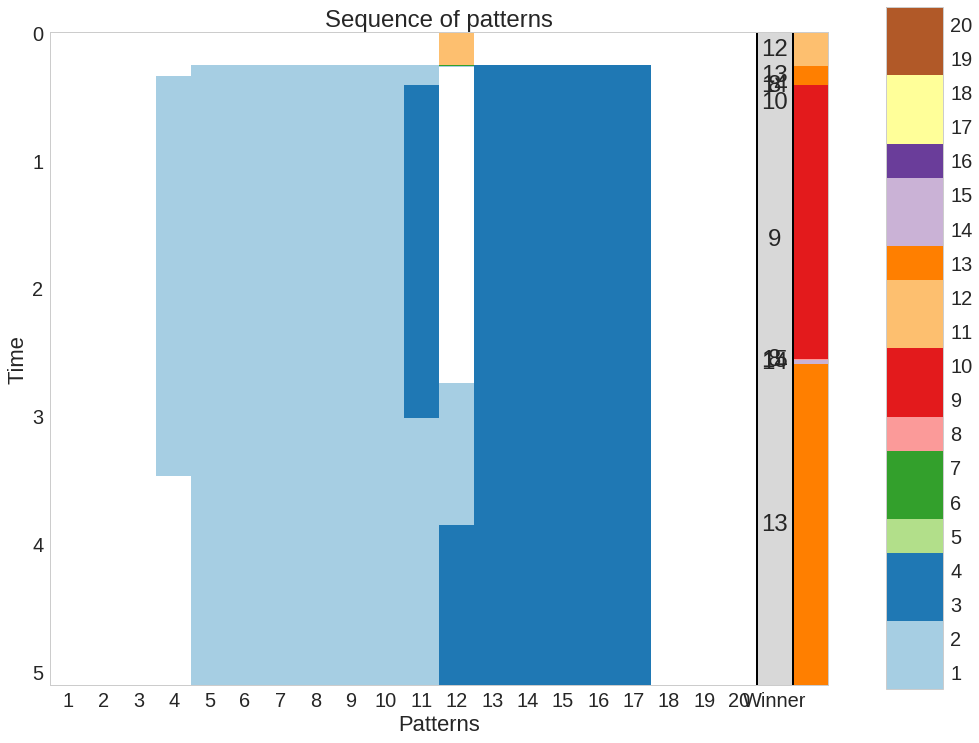

In [60]:
plot_winning_pattern(manager)

Let's check that the proper bridges are rightly placed

In [61]:
from_pattern = 4
to_pattern = 8
connectivity_bridge_1 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 4
to_pattern = 14
connectivity_bridge_2 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

print('bridge 1', connectivity_bridge_1)
print('bridge 2', connectivity_bridge_2)

('bridge 1', 0.029743852149483777)
('bridge 2', 0.028944208314690852)


## Same experiment for an artificial matrix

In [37]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20
n_patterns = 10

dt = 0.001

# Manager properties
dt = 0.001
T_recalling = 5.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

tau_z_pre = 0.050
sigma = 0.0

# Build chain protocol
overlap = 5
number_of_sequences = 2
half_width = 3
chain_protocol = Protocol()
units_to_overload = [i for i in range(overlap)]
sequences = chain_protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)
chain_protocol.cross_protocol(sequences, training_time=training_time,
                            inter_sequence_interval=inter_sequence_interval, epochs=epochs)
print(sequences)

# Artificial matrix
beta = False
value = 3
inhibition = -1
extension = 1
decay_factor = 0.3
sequence_decay = 0.0
tau_z_pre = 0.050
sigma = 0

manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value,
                                    inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor,
                                    sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True,
                                    beta=beta)

manager.nn.tau_z_pre = tau_z_pre
manager.nn.sigma = sigma

[[5, 6, 7, 0, 1, 2, 3, 4, 8, 9, 10], [11, 12, 13, 0, 1, 2, 3, 4, 14, 15, 16]]


In [38]:
from_pattern = 7
to_pattern = 8
connectivity_bridge_1 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 13
to_pattern = 8
connectivity_bridge_2 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

print('right bridge', connectivity_bridge_1)
print('wrong bridge', connectivity_bridge_2)

('right bridge', -1.0)
('wrong bridge', -1.0)


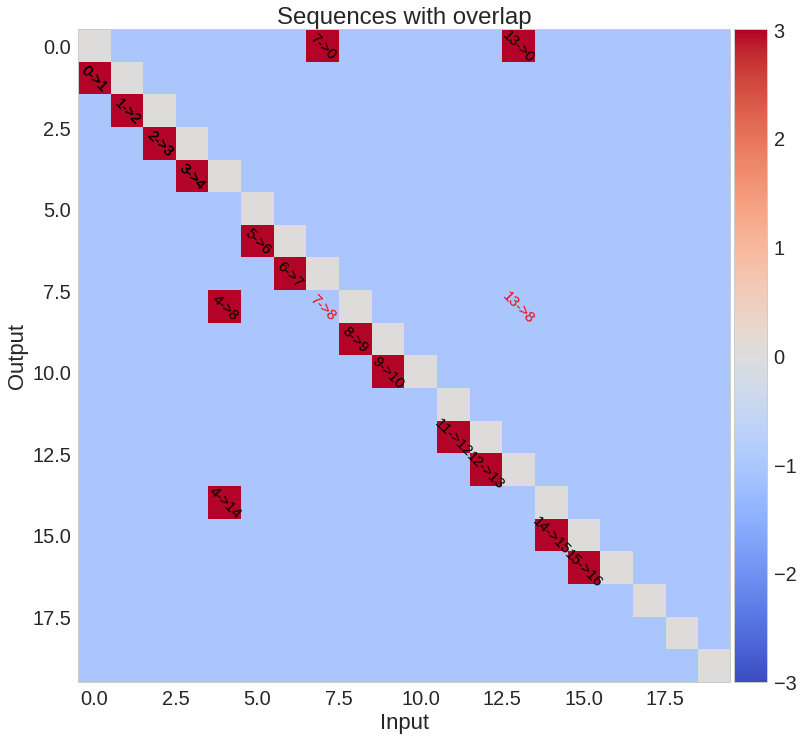

In [39]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

nn = manager.nn
w = nn.w
w = w[:nn.minicolumns, :nn.minicolumns]

aux_max = np.max(np.abs(w))

cmap = 'coolwarm'
im = ax.imshow(w, cmap=cmap, interpolation='None', vmin=-aux_max, vmax=aux_max)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.get_figure().colorbar(im, ax=ax, cax=cax)

# Add text
fontsize = 15
if True:
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            coordinate_from = sequence[i]
            coordinate_to = sequence[i + 1]
            set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize)

coordinate_from = 7
coordinate_to = 8
set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize, color='red')
        
coordinate_from = 13
coordinate_to = 8
set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize, color='red')   

# Editing
ax.grid(False)
ax.set_title('Sequences with overlap')
ax.set_xlabel('Input')
ax.set_ylabel('Output');

0.0


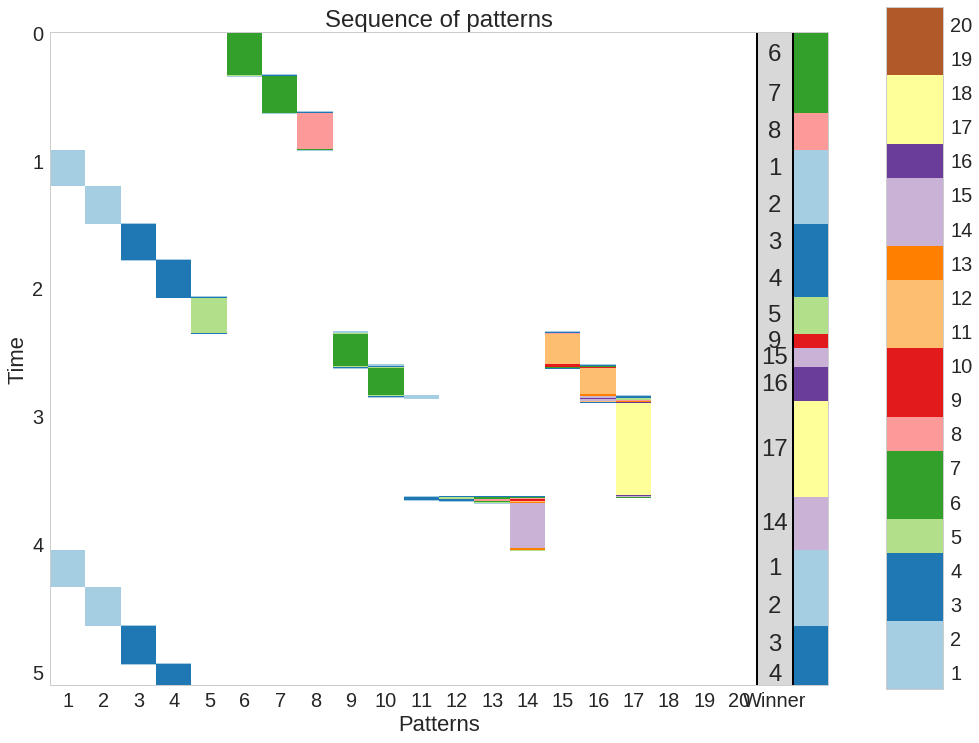

In [40]:
T_recall = 5.0
T_cue = 0.100
n = 1
patterns_indexes = sequences[0]
success_1 = calculate_recall_success(manager, T_recall=T_recall, I_cue=patterns_indexes[0],
                                     T_cue=T_cue, n=n, patterns_indexes=patterns_indexes)
print(success_1)
plot_winning_pattern(manager)

0.0


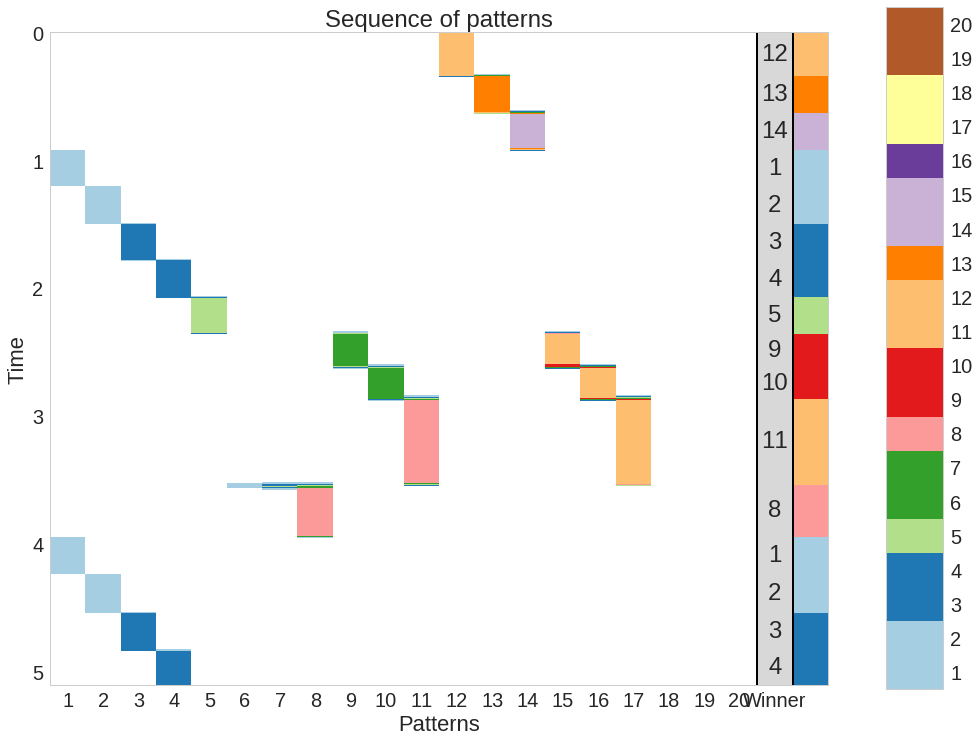

In [41]:
patterns_indexes = sequences[1]
success_2 = calculate_recall_success(manager, T_recall=T_recall, I_cue=patterns_indexes[0],
                                     T_cue=T_cue, n=n, patterns_indexes=patterns_indexes)
print(success_2)
plot_winning_pattern(manager)

In [42]:
from_pattern = 4
to_pattern = 8
connectivity_bridge_1 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 4
to_pattern = 14
connectivity_bridge_2 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

print('bridge 1', connectivity_bridge_1)
print('bridge 2', connectivity_bridge_2)

('bridge 1', 3.0)
('bridge 2', 3.0)


## Do sequences that are trained later have weaker inter-connections?

In [50]:
# Patterns parameters
hypercolumns = 4
minicolumns = 25

dt = 0.001

# Manager properties
dt = 0.001
T_recalling = 5.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 2.0
inter_pulse_interval = 0.0
epochs = 3

tau_z_pre = 0.150
sigma = 0
tau_p = 1000.0

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre, sigma=sigma, tau_p=tau_p)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build a protocol
protocol = Protocol()
sequences = [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19]]
protocol.cross_protocol(sequences, training_time=training_time,
                            inter_sequence_interval=inter_sequence_interval, epochs=epochs)
print(sequences)

# Train
manager.run_network_protocol(protocol=protocol, verbose=True)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19]]
('epochs', 0)
('epochs', 1)
('epochs', 2)


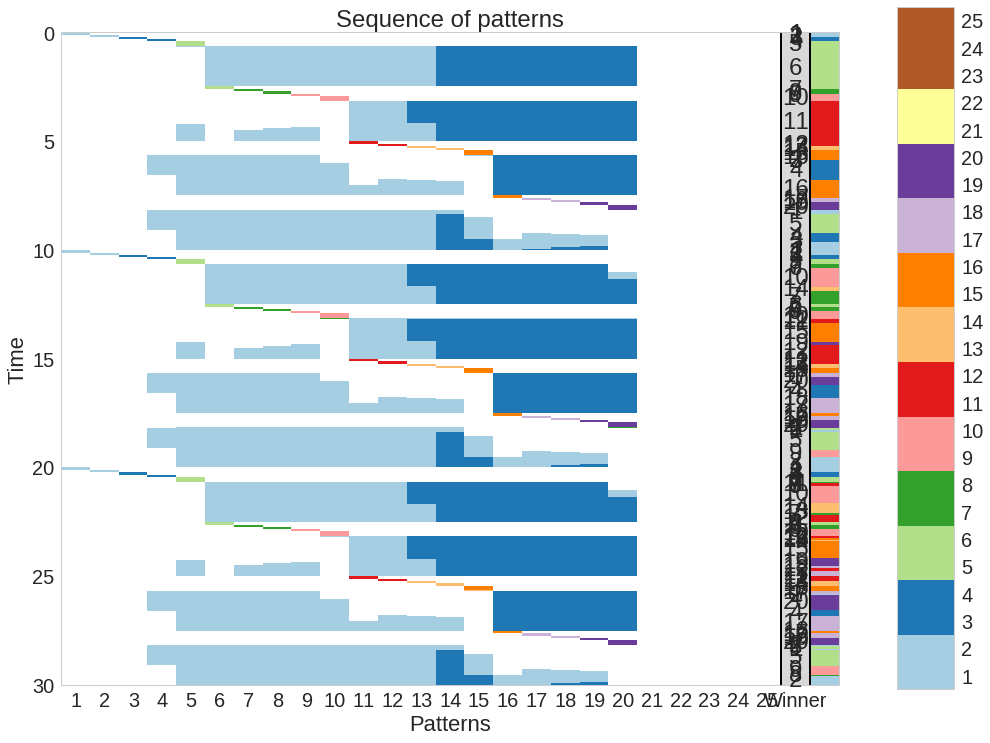

In [51]:
plot_winning_pattern(manager)

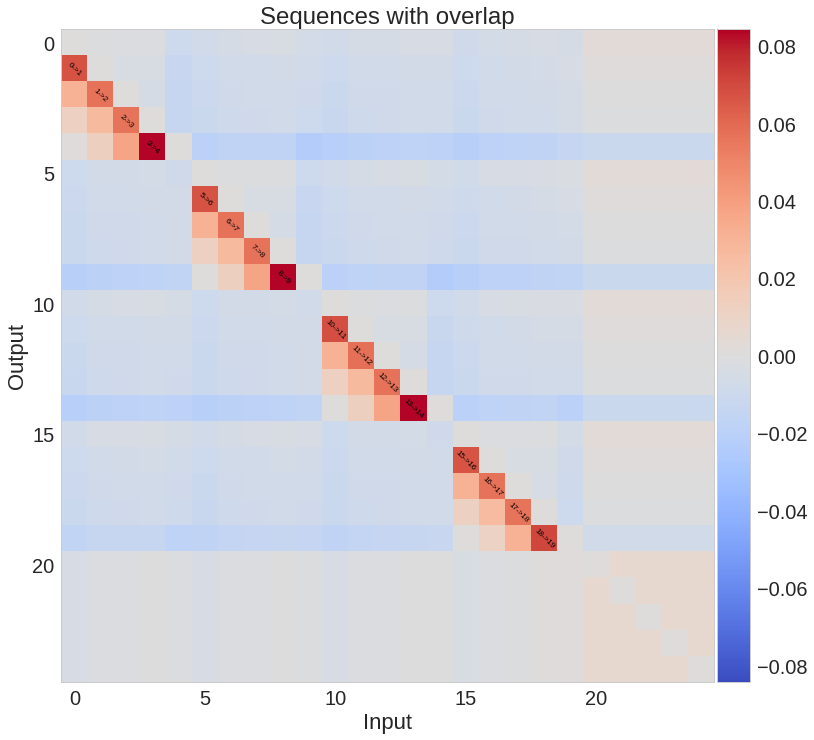

In [52]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

w = nn.w
w = w[:nn.minicolumns, :nn.minicolumns]

aux_max = np.max(np.abs(w))

cmap = 'coolwarm'
im = ax.imshow(w, cmap=cmap, interpolation='None', vmin=-aux_max, vmax=aux_max)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.get_figure().colorbar(im, ax=ax, cax=cax)

# Add text
fontsize = 8
if True:
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            coordinate_from = sequence[i]
            coordinate_to = sequence[i + 1]
            set_text(ax, coordinate_from=coordinate_from, coordinate_to=coordinate_to, fontsize=fontsize)

# Editing
ax.grid(False)
ax.set_title('Sequences with overlap')
ax.set_xlabel('Input')
ax.set_ylabel('Output');

Let's quantify the interconnections

In [53]:
from_pattern = 3
to_pattern = 4
connectivity_seq_1 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 8
to_pattern = 9
connectivity_seq_2 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 13
to_pattern = 14
connectivity_seq_3 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 13
to_pattern = 14
connectivity_seq_3 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)

from_pattern = 18
to_pattern = 19
connectivity_seq_4 = calculate_total_connections(manager, from_pattern, to_pattern, ampa=False, normalize=True)


print('connectivit 1', connectivity_seq_1)
print('connectivit 2', connectivity_seq_2)
print('connectivit 3', connectivity_seq_3)
print('connectivit 4', connectivity_seq_4)

('connectivit 1', 0.083978461076418626)
('connectivit 2', 0.084147150482751953)
('connectivit 3', 0.084256526975836549)
('connectivit 4', 0.070757150252992174)


## Effect of epsilon in the overall inhibition of the system

#### Git machinery

In [16]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])